# Urban Heat Risk Analysis for Critical Infrastructure

## Objective
Identify hospitals in Bengaluru that are relatively more vulnerable to extreme heat, using open geospatial data and an explainable risk-scoring framework.

## What this project is?
A decision-support analysis to help prioritize critical infrastructure under climate stress.



In [1]:
!pip install geopandas osmnx folium streamlit pyproj shapely


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 14.9 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import osmnx as ox
import folium
import pandas as pd
import numpy as np

print("Environment ready — all libraries imported.")


Environment ready — all libraries imported.


## Mental model

- I am not predicting future heat.
- I am not building a scientific climate model.

I am:
- mapping hospitals
- understanding relative heat exposure
- assigning explainable risk scores
- helping prioritize attention

This is a prioritization and decision-support project.


## Infrastructure Data: Hospitals

This section fetches hospital locations from OpenStreetMap
and validates their spatial accuracy within Bengaluru.


In [3]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt


In [4]:
place_name = "Bengaluru, Karnataka, India"


In [5]:
bengaluru = ox.geocode_to_gdf(place_name)

# Use standard geographic CRS
bengaluru = bengaluru.to_crs(epsg=4326)

bengaluru


,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((77.45988 12.90469, 77.45998 12.90326...",77.45988,12.83349,77.784064,13.14262,422572170,relation,7902476,12.976794,77.590082,boundary,administrative,14,0.636465,city,Bengaluru,"Bengaluru, Bangalore North, Bengaluru Urban, K..."


In [6]:
hospitals = ox.features_from_place(
    place_name,
    tags={"amenity": "hospital"}
)

hospitals = hospitals.to_crs(epsg=4326)

# Keep only essential columns
hospitals = hospitals[["name", "geometry"]].reset_index(drop=True)

print(f"Hospitals found: {len(hospitals)}")
hospitals.head()


Hospitals found: 1059


,name,geometry
0,Clinic,POINT (77.67749 12.91342)
1,Shanti Hospital,POINT (77.58575 12.9235)
2,Apollo Hospital,POINT (77.67655 12.92637)
3,Narayana Hrudayalaya Dental Clinic,POINT (77.63499 12.91558)
4,Dr Ganesh Medical and Diabetic Clinic,POINT (77.64191 12.9129)


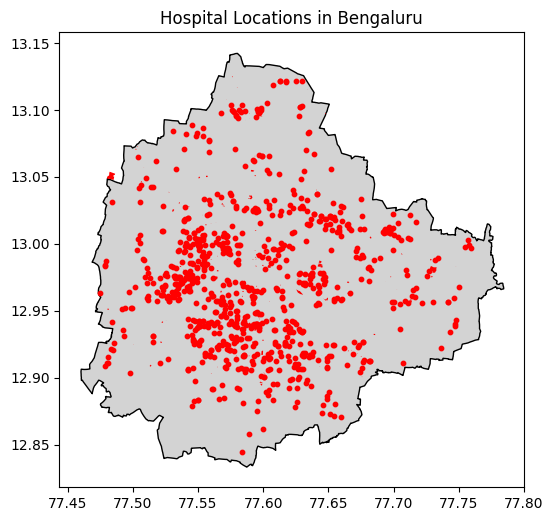

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

bengaluru.plot(ax=ax, color="lightgrey", edgecolor="black")
hospitals.plot(ax=ax, color="red", markersize=10)

ax.set_title("Hospital Locations in Bengaluru")
plt.show()


In [8]:
hospitals.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      1046 non-null   object  
 1   geometry  1059 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 16.7+ KB


In [9]:
hospitals.to_file(
    "bengaluru_hospitals.geojson",
    driver="GeoJSON"
)


## Heat Exposure (Proxy)

This section assigns a relative heat exposure score to hospitals.
At this stage, exposure is represented using a placeholder proxy,
to demonstrate the risk-scoring logic.


In [10]:
import geopandas as gpd
import numpy as np

hospitals = gpd.read_file("bengaluru_hospitals.geojson")


### Exposure scale (1–5)

- 1 → Relatively cooler areas
- 3 → Moderate heat exposure
- 5 → High heat exposure

This represents *relative* heat stress across the city,
not measured temperature.


In [11]:
np.random.seed(42)  # reproducibility

hospitals["Exposure"] = np.random.randint(
    low=1,
    high=6,
    size=len(hospitals)
)

hospitals[["name", "Exposure"]].head()


,name,Exposure
0,Clinic,4
1,Shanti Hospital,5
2,Apollo Hospital,3
3,Narayana Hrudayalaya Dental Clinic,5
4,Dr Ganesh Medical and Diabetic Clinic,5


In [12]:
hospitals["Exposure"].value_counts().sort_index()


,count
Exposure,
1,225
2,201
3,202
4,217
5,214


In [13]:
hospitals.to_file(
    "bengaluru_hospitals_with_exposure.geojson",
    driver="GeoJSON"
)


## Risk Scoring Framework

This section combines heat exposure, asset sensitivity,
and adaptive capacity into a single, explainable risk score
to prioritize critical infrastructure.


In [14]:
import geopandas as gpd
import numpy as np

hospitals = gpd.read_file(
    "bengaluru_hospitals_with_exposure.geojson"
)


In [15]:
hospitals["Sensitivity"] = 5


In [16]:
np.random.seed(24)  # different seed from exposure

hospitals["Adaptive_Capacity"] = np.random.randint(
    low=1,
    high=6,
    size=len(hospitals)
)

hospitals[["name", "Adaptive_Capacity"]].head()


,name,Adaptive_Capacity
0,Clinic,3
1,Shanti Hospital,4
2,Apollo Hospital,1
3,Narayana Hrudayalaya Dental Clinic,2
4,Dr Ganesh Medical and Diabetic Clinic,2


### Risk score formulation

Risk is calculated as:

Risk Score = (Exposure × Sensitivity) − Adaptive Capacity

This reflects the idea that:
- higher heat exposure increases risk
- critical assets amplify impact
- local cooling reduces vulnerability

The score represents relative risk, not absolute danger.


In [17]:
# Risk Score Calcuation using Multiplication

hospitals["Risk_Score"] = (
    (hospitals["Exposure"] * hospitals["Sensitivity"]) -
    hospitals["Adaptive_Capacity"]
)

# Display updated table
hospitals[["name", "Exposure", "Sensitivity", "Adaptive_Capacity", "Risk_Score"]].head()

,name,Exposure,Sensitivity,Adaptive_Capacity,Risk_Score
0,Clinic,4,5,3,17
1,Shanti Hospital,5,5,4,21
2,Apollo Hospital,3,5,1,14
3,Narayana Hrudayalaya Dental Clinic,5,5,2,23
4,Dr Ganesh Medical and Diabetic Clinic,5,5,2,23


In [18]:
def classify_risk(score):
    if score >= 18:
        return "High"
    elif score >= 10:
        return "Medium"
    else:
        return "Low"

hospitals["Risk_Level"] = hospitals["Risk_Score"].apply(classify_risk)

hospitals["Risk_Level"].value_counts()


,count
Risk_Level,
Low,426
Medium,348
High,285


In [19]:
hospitals.to_file(
    "bengaluru_hospitals_with_risk.geojson",
    driver="GeoJSON"
)


## Visualization: Hospital Heat Risk Map

This section visualizes hospital heat risk across Bengaluru
to support intuitive understanding and prioritization.


In [20]:
import geopandas as gpd
import folium


In [21]:
hospitals = gpd.read_file("bengaluru_hospitals_with_risk.geojson")
hospitals.head()


,name,Exposure,Sensitivity,Adaptive_Capacity,Risk_Score,Risk_Level,geometry
0,Clinic,4,5,3,17,Medium,POINT (77.67749 12.91342)
1,Shanti Hospital,5,5,4,21,High,POINT (77.58575 12.9235)
2,Apollo Hospital,3,5,1,14,Medium,POINT (77.67655 12.92637)
3,Narayana Hrudayalaya Dental Clinic,5,5,2,23,High,POINT (77.63499 12.91558)
4,Dr Ganesh Medical and Diabetic Clinic,5,5,2,23,High,POINT (77.64191 12.9129)


In [22]:
# Approximate center of Bengaluru
center_lat, center_lon = 12.9716, 77.5946

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles="cartodb dark_matter"
)


In [23]:
risk_colors = {
    "High": "red",
    "Medium": "orange",
    "Low": "green"
}


In [24]:
for _, row in hospitals.iterrows():
    if row.geometry.geom_type == "Point":
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=6,
            color=risk_colors.get(row["Risk_Level"], "gray"),
            fill=True,
            fill_opacity=0.8,
            popup=(
                f"<b>{row['name']}</b><br>"
                f"Risk Level: {row['Risk_Level']}<br>"
                f"Risk Score: {row['Risk_Score']}<br>"
                f"Exposure: {row['Exposure']}<br>"
                f"Adaptive Capacity: {row['Adaptive_Capacity']}"
            )
        ).add_to(m)


In [25]:
m


In [26]:
m.save("bengaluru_hospital_heat_risk_map.html")


In [27]:
%%writefile app.py
import streamlit as st
import geopandas as gpd
import folium
from streamlit.components.v1 import html

st.set_page_config(page_title="Urban Heat Risk", layout="wide")
hospitals = gpd.read_file("bengaluru_hospitals_with_risk.geojson")

st.title("Bengaluru Hospitals Heat Risk Analysis Map")
col1, col2 = st.columns(2)
col1.metric("Total Sites", len(hospitals))
col2.metric("High Risk", (hospitals["Risk_Level"]=="High").sum())

m = folium.Map(location=[12.9716, 77.5946], zoom_start=11, tiles="cartodb dark_matter")
colors = {"High": "red", "Medium": "orange", "Low": "green"}

for _, row in hospitals.iterrows():
    if row.geometry.geom_type == "Point":
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5, color=colors.get(row["Risk_Level"], "gray"),
            fill=True, popup=row["name"]
        ).add_to(m)

html(m._repr_html_(), height=500)

Writing app.py


In [28]:
!ls


app.py
bengaluru_hospital_heat_risk_map.html
bengaluru_hospitals.geojson
bengaluru_hospitals_with_exposure.geojson
bengaluru_hospitals_with_risk.geojson
cache
sample_data


In [29]:
import os
# Files to remove to keep the directory clean
files_to_clean = [
    "bengaluru_hospitals.geojson",
    "bengaluru_hospitals_with_exposure.geojson"
]

for f in files_to_clean:
    if os.path.exists(f):
        os.remove(f)
        print(f"Removed intermediate file: {f}")

Removed intermediate file: bengaluru_hospitals.geojson
Removed intermediate file: bengaluru_hospitals_with_exposure.geojson


In [30]:
import os

# Clean up intermediate files
for f in ["bengaluru_hospitals.geojson", "bengaluru_hospitals_with_exposure.geojson"]:
    if os.path.exists(f):
        os.remove(f)

# Verify final files remaining
print("Files in directory:", [f for f in os.listdir() if "geojson" in f or "py" in f])

Files in directory: ['app.py', 'bengaluru_hospitals_with_risk.geojson']


In [31]:
# 1. Install localtunnel to expose the port
!npm install -g localtunnel

# 2. Run streamlit in the background
import subprocess
subprocess.Popen(["streamlit", "run", "app.py"])

# 3. Get your IP address (you will need to paste this into the website that opens)
import urllib
print("Password/Enpoint IP for localtunnel is:", urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip())

# 4. Create the tunnel
!npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
added 22 packages in 2s
⠸
⠸3 packages are looking for funding
⠸  run `npm fund` for details
⠸Password/Enpoint IP for localtunnel is: 34.143.130.229
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴your url is: https://new-kings-speak.loca.lt
^C
